In [ ]:
#Add google drive
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
#Add link to shared cross section library
#shared library was added as a shortcut to My Drive from the web interface
%env OPENMC_CROSS_SECTIONS = /gdrive/My Drive/data/endfb71_hdf5/cross_sections.xml

In [ ]:
#Download miniconda and install
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
# Install OpenMC
!conda config --add channels conda-forge
!conda install openmc -y

In [1]:
import openmc

In [ ]:
%matplotlib inline

In [ ]:
#I will building a mini vver pin-cell. 

This week tasks

In [ ]:
""" 
 
Use the openmc.model.pin function (https://docs.openmc.org/en/latest/pythonapi/generated/openmc.model.pin.html?highlight=openmc.model#openmc-model-pin)
Use the openmc.model.hex_prism or rect_prism functions when applicable
Use the borated water function (even if you need to set boron to 0ppm, this function will automatically lookup water properties for the temperature you give it)
Clean you your models of pins and assemblies (or small cores), and identify places to simplify the input
 
And here is a list of simpler functions that we can start working  on:
 
Add Gd2O3 calculations to the uranium enrichment function (we can also add Erbium, Dysprosium , …)
Add models for IFBA, WABA, …
Add pre-defined structural materials
Create/use the lattice acceleration method for non-TRISO geometries (TRIGA and RBMK)
Use CMFD for non Cartesian geometries
Function to create circular lattices like RBMK, CANDU
Function to create a BWR box with thin/thick geometry
Function to position control rod height
Function to create tallies for breeding ratio, fissile inventory ratio
Functions for thermodynamic properties of other coolants (Sodium, He, Heavy water, …)
"""

VVER sheet

In [2]:
# defining materials for 4 types of pincells. 
#fuels
au13=openmc.Material(name='13au',material_id=1)
au13.add_element('U',1.0,enrichment=1.3)
au13.add_element('O',2.0)
au13.set_density('g/cc', 10.4)

au22=openmc.Material(name='13au',material_id=2)
au22.add_element('U',1.0,enrichment=2.2)
au22.add_element('O',2.0)
au22.set_density('g/cc', 10.4)

av5=openmc.Material(name='30av5u',material_id=3)
av5.add_element('U',1.0,enrichment=3.0)
av5.add_element('O',2.0)
av5.set_density('g/cc', 10.4)

awu=openmc.Material(name='39awu',material_id=4)
awu.add_element('U',1.0,enrichment=3.3)
awu.add_element('O',2.0)
awu.set_density('g/cc', 10.4)

go=openmc.Material(name='390go',material_id=5)
go.add_element('U',1.0,enrichment=4.0)
go.add_element('O',2.0)
go.set_density('g/cc', 10.4)

Gd2O3=openmc.Material(name='Gd2O3',material_id=6)
Gd2O3.add_element('Gd',2.0)#>>>? Gd153
Gd2O3.add_element('O',3.0)
Gd2O3.set_density('g/cm3',7.41)

#moderator
water = openmc.Material(name='water',material_id=7)
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

#clad
zirconium = openmc.Material(name="zirconium",material_id=8)
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

niobium=openmc.Material(name='niobium',material_id=9)
niobium.add_element('Nb',1.0)
niobium.set_density('g/cm3',8.57)

#gap
helium=openmc.Material(name='Helium',material_id=10)
helium.add_element('He',1.0)
helium.set_density('g/cm3',0.178*10**(-3))

#reflector
reflector_mat = openmc.Material(material_id=12)
reflector_mat.add_nuclide('Be9',1.0)
reflector_mat.add_nuclide('O16',1.0)
reflector_mat.set_density('g/cm3',2.9)

In [3]:
#preparing mixtures
alloy=openmc.Material.mix_materials([niobium, zirconium],[0.01, 0.99],'wo')
fuel_awu = openmc.Material.mix_materials([Gd2O3, awu], [0.05, 0.95], 'wo')
fuel_go = openmc.Material.mix_materials([Gd2O3, go], [0.05, 0.95], 'wo')

In [4]:
# Instantiate a Materials collection
materials_file = openmc.Materials([au13, au22, av5, fuel_awu, fuel_go, water, alloy, helium, reflector_mat])

# Export to "materials.xml"
materials_file.export_to_xml()

In [5]:
# Designing General Geometry

# boudries and outer universe
all_water_out=openmc.Cell(cell_id=200,fill=water)

# top & bottom of the assembly 
assembly_z0 = openmc.ZPlane(surface_id=300,z0=-75)
assembly_z1 = openmc.ZPlane(surface_id=301, z0=75)
assembly = openmc.model.hexagonal_prism(edge_length=18, orientation='y')

# top & bottom of the reflector
reflector_z0 = openmc.ZPlane(surface_id=303,z0=-95, boundary_type='vacuum')
reflector_z1 = openmc.ZPlane(surface_id=304,z0=95, boundary_type='vacuum')

# reflector hexagon
reflector = openmc.model.hexagonal_prism(edge_length=19, orientation='y',
    boundary_type='vacuum')

assembly_cell = openmc.Cell()
reflect_cell = openmc.Cell()
top_reflect_cell = openmc.Cell()
bot_reflect_cell = openmc.Cell()


In [6]:

#regions

assembly_cell.region = assembly & -assembly_z1 & +assembly_z0

reflect_cell.region = ~assembly & reflector \
& -assembly_z1 & +assembly_z0

top_reflect_cell.region = reflector & +assembly_z1 & -reflector_z1

bot_reflect_cell.region = reflector & -assembly_z0 & +reflector_z0

reflect_cell.fill = reflector_mat
top_reflect_cell.fill = reflector_mat
bot_reflect_cell.fill = reflector_mat

#turn cell to universe to make it easier
all_water_out_u=openmc.Universe(cells=[all_water_out])
u_reflect = openmc.Universe(cells=(reflect_cell,top_reflect_cell,bot_reflect_cell))
u_root = openmc.Universe()


In [7]:
# centeral tube >> water

fuel_or1 = openmc.ZCylinder(surface_id=400, r=0.3765)
clad_ir1 = openmc.ZCylinder(surface_id=401, r=0.4)
clad_or1 = openmc.ZCylinder(surface_id=402, r=0.465)

fuel_region1 = -fuel_or1 & -assembly_z1 & +assembly_z0
clad_region1 = +fuel_or1 & -clad_or1 & -assembly_z1 & +assembly_z0

moderator_region1 = +clad_or1 & -assembly_z1 & +assembly_z0 

fuel_cell1  = openmc.Cell(cell_id=400, fill=water, region=fuel_region1)
cladcell1   = openmc.Cell(cell_id=401, fill=alloy, region=clad_region1)
water_cell1 = openmc.Cell(cell_id=402, fill=water, region=moderator_region1)

central_tube_u = openmc.Universe(cells=[fuel_cell1,cladcell1,water_cell1])

In [8]:
# geometry of 13 au

fuel_or2 = openmc.ZCylinder(surface_id=410, r=0.3765)
clad_ir2 = openmc.ZCylinder(surface_id=411, r=0.4)
clad_or2 = openmc.ZCylinder(surface_id=412, r=0.465)

fuel_region2 = -fuel_or2 & -assembly_z1 & +assembly_z0
gap_region2  = +fuel_or2 & -clad_ir2 & -assembly_z1 & +assembly_z0
clad_region2 = +clad_ir2 & -clad_or2 & -assembly_z1 & +assembly_z0

moderator_region2 = +clad_or2 & -assembly_z1 & +assembly_z0 

fuel_cell2  = openmc.Cell(cell_id=410, fill=au13,   region=fuel_region2)
gap_cell2   = openmc.Cell(cell_id=411, fill=helium, region=gap_region2)
cladcell2   = openmc.Cell(cell_id=412, fill=alloy,  region=clad_region2)
water_cell2 = openmc.Cell(cell_id=413, fill=water,  region=moderator_region2)

au13_u = openmc.Universe(cells=[fuel_cell2,gap_cell2,cladcell2,water_cell2])

# geom = openmc.Geometry(au13_u)
# geom.export_to_xml()
# au13_u.plot(colors={water_cell2:'blue'},width=(3,3))

In [9]:
#geometry of 22 au

fuel_or3 = openmc.ZCylinder(surface_id=420, r=0.3765)
clad_ir3 = openmc.ZCylinder(surface_id=421, r=0.4)
clad_or3 = openmc.ZCylinder(surface_id=422, r=0.465)

fuel_region3 = -fuel_or3 & -assembly_z1 & +assembly_z0
gap_region3  = +fuel_or3 & -clad_ir3 & -assembly_z1 & +assembly_z0
clad_region3 = +clad_ir3 & -clad_or3 & -assembly_z1 & +assembly_z0

moderator_region3 = +clad_or3 & -assembly_z1 & +assembly_z0 

fuel_cell3  = openmc.Cell(cell_id=420, fill=au22,   region=fuel_region3)
gap_cell3   = openmc.Cell(cell_id=421, fill=helium, region=gap_region3)
cladcell3   = openmc.Cell(cell_id=422, fill=alloy,  region=clad_region3)
water_cell3 = openmc.Cell(cell_id=423, fill=water,  region=moderator_region3)

au22_u = openmc.Universe(cells=[fuel_cell3,gap_cell3,cladcell3,water_cell3])

# geom = openmc.Geometry(au22_u)
# geom.export_to_xml()
# au22_u.plot(colors={water_cell3:'blue'},width=(3,3))

In [10]:
#geometry av5

fuel_or4 = openmc.ZCylinder(surface_id=430, r=0.3765)
clad_ir4 = openmc.ZCylinder(surface_id=431, r=0.4)
clad_or4 = openmc.ZCylinder(surface_id=432, r=0.465)

fuel_region4 = -fuel_or4 & -assembly_z1 & +assembly_z0
gap_region4  = +fuel_or4 & -clad_ir4 & -assembly_z1 & +assembly_z0
clad_region4 = +clad_ir4 & -clad_or4 & -assembly_z1 & +assembly_z0

moderator_region4 = +clad_or4 & -assembly_z1 & +assembly_z0 

fuel_cell4  = openmc.Cell(cell_id=430, fill=av5,    region=fuel_region4)
gap_cell4   = openmc.Cell(cell_id=431, fill=helium, region=gap_region4)
cladcell4   = openmc.Cell(cell_id=432, fill=alloy,  region=clad_region4)
water_cell4 = openmc.Cell(cell_id=433, fill=water,  region=moderator_region4)

av5_u = openmc.Universe(cells=[fuel_cell4,gap_cell4,cladcell4,water_cell4])

# geom = openmc.Geometry(av5_u)
# geom.export_to_xml()
# av5_u.plot(colors={water_cell4:'blue'},width=(3,3))

In [11]:
#geometry of awu

fuel_or5 = openmc.ZCylinder(surface_id=440, r=0.3765)
clad_ir5 = openmc.ZCylinder(surface_id=441, r=0.4)
clad_or5 = openmc.ZCylinder(surface_id=442, r=0.465)

fuel_region5 = -fuel_or5 & -assembly_z1 & +assembly_z0
gap_region5  = +fuel_or5 & -clad_ir5 & -assembly_z1 & +assembly_z0
clad_region5 = +clad_ir5 & -clad_or5 & -assembly_z1 & +assembly_z0

moderator_region5 = +clad_or5 & -assembly_z1 & +assembly_z0 

fuel_cell5  =openmc.Cell(cell_id=440, fill=fuel_awu, region=fuel_region5)
gap_cell5   =openmc.Cell(cell_id=441, fill=helium,   region=gap_region5)
cladcell5   =openmc.Cell(cell_id=442, fill=alloy,    region=clad_region5)
water_cell5 =openmc.Cell(cell_id=443, fill=water,    region=moderator_region5)

awu_u = openmc.Universe(cells=[fuel_cell5,gap_cell5,cladcell5,water_cell5])

# geom = openmc.Geometry(awu_u)
# geom.export_to_xml()
# awu_u.plot(colors={water_cell5:'blue'},width=(3,3))

In [12]:
#geometry of go

fuel_or6 = openmc.ZCylinder(surface_id=450, r=0.3765)
clad_ir6 = openmc.ZCylinder(surface_id=451, r=0.4)
clad_or6 = openmc.ZCylinder(surface_id=452, r=0.465)

fuel_region6 = -fuel_or6 & -assembly_z1 & +assembly_z0
gap_region6  = +fuel_or6 & -clad_ir6 & -assembly_z1 & +assembly_z0
clad_region6 = +clad_ir6 & -clad_or6 & -assembly_z1 & +assembly_z0

moderator_region6 = +clad_or6 & -assembly_z1 & +assembly_z0 

fuel_cell6  = openmc.Cell(cell_id=450, fill=fuel_go, region=fuel_region6)
gap_cell6   = openmc.Cell(cell_id=451, fill=helium,  region=gap_region6)
cladcell6   = openmc.Cell(cell_id=452, fill=alloy,   region=clad_region6)
water_cell6 = openmc.Cell(cell_id=453, fill=water,   region=moderator_region6)

go_u = openmc.Universe(cells=[fuel_cell6,gap_cell6,cladcell6,water_cell6])

# geom = openmc.Geometry(go_u)
# geom.export_to_xml()
# go_u.plot(colors={water_cell6:'blue'},width=(3,3))

Reactor core:/

In [13]:
# we have 163 pincell, .... 
"""
 Number of assemblies
13au 48
22au 42 
30av5 37 
39awu 24 
390go 12
"""
lat=openmc.HexLattice(name='assembly')
lat.center = (0., 0.)
lat.pitch = (1.275,)###
lat.outer=all_water_out_u

#lat.outer = u_monolith
#lat.orientation='x'
# print(lat.show_indices(7,orientation='x')) # with 7 cycles we would have 169 pincell, but we know that 6 pincell are removed according to graphs.

In [14]:
#ring8=[central_tube_u]*48
#ring7=[awu_u, awu_u, go_u, centeral_tube_u, go_u, awu_u, awu_u]*6
ring7=[awu_u, awu_u, go_u,awu_u, go_u, awu_u, awu_u]*6

#ring7=[au22_u, au13_u, au22_u, av5_u, av5_u,au13_u, av5_u]*6
ring6= [au22_u, av5_u, au22_u,
        av5_u, au22_u, av5_u,
        au13_u,av5_u, au22_u,
        av5_u,au22_u,av5_u,
        au22_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au22_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au13_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au13_u,av5_u,au22_u,
        av5_u,au22_u,av5_u]
ring5= [au13_u, au13_u, au22_u, au13_u, au13_u]*6
ring4=[au22_u, av5_u, au13_u, av5_u]*6
ring3=[au13_u, au22_u, au13_u]*6
ring2=[au22_u, av5_u]*6
ring1=[au13_u]*6
ring0=[central_tube_u]
lat.universes = [ring7, ring6, ring5, ring4, ring3, ring2, ring1, ring0]
lat.orientation='y'

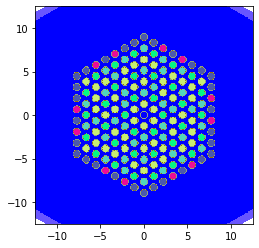

In [15]:
#outer_surface=openmc.model.hexagonal_prism(edge_length=18, orientation='y')
#main_assembly = openmc.Cell(fill=lat, region=outer_surface)
#main_u=openmc.Universe(cells=[main_assembly])

assembly_cell.fill = lat

u_root.add_cells([assembly_cell, reflect_cell, top_reflect_cell, bot_reflect_cell])
geom=openmc.Geometry(u_root)
geom.export_to_xml()

u_root.plot(origin=(0,0,0),width=(25,25),color_by='material',colors={water:'blue'},pixels=[400,400])
#u_root.plot(origin=(0,0,0),width=(25,25),color_by='material',pixels=[400,400])

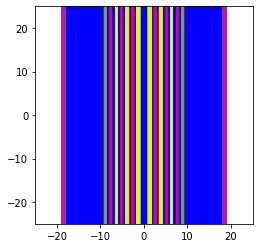

In [24]:
u_root.plot(basis='yz',origin=(0,0,0),width=(50,50),color_by='material',colors={water:'blue'},pixels=[200,200])

In [16]:
#######################
# Run Settings
######################

uniform_dist = openmc.stats.Box([-24,-24,-75],[24,24,75],only_fissionable=True)

settings = openmc.Settings()
settings.seed = 1
settings.batches = 200
settings.inactive = 100
settings.particles = 100
settings.source = openmc.source.Source(space=uniform_dist)
settings.export_to_xml()


In [ ]:

#openmc.run()
!cat materials.xml


In [ ]:
# for control rodes 
#materials for rodes
def insert_rode(pitch,rode_type)
  

In [17]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      159/1    0.37579    0.36460 +/- 0.01078
      160/1    0.34382    0.36425 +/- 0.01060
      161/1    0.46415    0.36589 +/- 0.01055
      162/1    0.38444    0.36619 +/- 0.01039
      163/1    0.38400    0.36647 +/- 0.01022
      164/1    0.33748    0.36602 +/- 0.01007
      165/1    0.38155    0.36626 +/- 0.00992
      166/1    0.27878    0.36493 +/- 0.00986
      167/1    0.31949    0.36425 +/- 0.00973
      168/1    0.24262    0.36247 +/- 0.00975
      169/1    0.35539    0.36236 +/- 0.00961
      170/1    0.33345    0.36195 +/- 0.00948
      171/1    0.39638    0.36244 +/- 0.00936
      172/1    0.43415    0.36343 +/- 0.00928
      173/1    0.27590    0.36223 +/- 0.00923
      174/1    0.38740    0.36257 +/- 0.00911
      175/1    0.38717    0.36290 +/- 0.00900
      176/1    0.49158    0.36459 +/- 0.00904
      177/1    0.36227    0.36456 +/- 0.00892
      178/1    0.35452    0.36443 +/- 0.00881
      179/1    0.32555    0.36394 +/- 0.00871
      180/1    0.38891    0.36425 